In [1]:
### this is a revised notebook to cluster attackers based on distance (closest to each other in terms of performance)
### spatial distance is used to perform distance based clustring instead of K-means and DBSCAN used in feature_selection.ipynb

### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

### Data

In [4]:
df_all = pd.read_csv('players_2024_2025_cleaned.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'players_2024_2025_cleaned.csv'

### Merging data

In [4]:
df_all.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist,Market Value,Market Value Euros
0,1,max aarons,eng ENG,DF,Bournemouth,eng Premier League,25,2000,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,16000000
1,2,max aarons,eng ENG,MF,Valencia,es La Liga,25,2000,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,16000000
2,3,rodrigo abajas,es ESP,DF,Valencia,es La Liga,21,2003,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100000
3,4,james abankwah,ie IRL,"DF,MF",Udinese,it Serie A,21,2004,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800.0,800000
4,6,yunis abdelhamid,ma MAR,DF,Saint-Ãtienne,fr Ligue 1,37,1987,12,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,500000


In [5]:
# Filtering the data by field_positoin for Forward players only
attacker_pos = ['FW', 'FW,MF', 'MF,FW']
attackers_df = df_all[df_all['Pos'].isin(attacker_pos)]
attackers_df

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist,Market Value,Market Value Euros
5,7,himad abdelli,dz ALG,"MF,FW",Angers,fr Ligue 1,25,1999,22,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000000
10,14,matthis abline,fr FRA,FW,Nantes,fr Ligue 1,21,2003,23,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9000.0,9000000
12,16,zakaria aboukhlal,ma MAR,"MF,FW",Toulouse,fr Ligue 1,25,2000,23,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,10000000
14,18,tammy abraham,eng ENG,FW,Roma,it Serie A,27,1997,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000.0,20000000
15,19,tammy abraham,eng ENG,FW,Milan,it Serie A,27,1997,20,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000.0,20000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2691,anass zaroury,ma MAR,"FW,MF",Lens,fr Ligue 1,24,2000,18,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000.0,8000000
1997,2704,edon zhegrova,xk KVX,"FW,MF",Lille,fr Ligue 1,25,1999,12,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25000.0,25000000
1999,2707,joshua zirkzee,nl NED,"FW,MF",Manchester Utd,eng Premier League,23,2001,26,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42000.0,42000000
2000,2708,budu zivzivadze,ge GEO,FW,Heidenheim,de Bundesliga,30,1994,8,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1800.0,1800000


### Feature selection and preprocessing

In [22]:
# Feature selection
attackers_features = ['Gls', 'G-PK', 'PKatt', 'Ast', 'xG', 'npxG', 'Sh/90', 'SoT/90',
                     'G/SoT', 'Off',]
attackers_features_renamed = ['Goals', 'Goals from PK', 'PK attempts', 'Assists', 'Expected Goals', 'Non PK Expected Goals',
                             'Shots per 90 mins', 'Shots on Target per 90 mins', 'Goals per Shots on Target', 'Offsides']

# DataFrame with attackers features
X = attackers_df[attackers_features].copy()
X = X.rename(columns={'Gls':'Goals', 'G-PK':'Goals from PK', 'PKatt':'PK attempts', 'Ast':'Assists', 'xG':'Expected Goals', 
                      'npxG':'Non PK Expected Goals', 'Sh/90':'Shots per 90 mins', 'SoT/90':'Shots on Target per 90 mins',
                     'G/SoT':'Goals per Shots on Target', 'Off':'Offsides',})
X

,Goals,Goals from PK,PK attempts,Assists,Expected Goals,Non PK Expected Goals,Shots per 90 mins,Shots on Target per 90 mins,Goals per Shots on Target,Offsides
5,6,3,4,1,5.5,2.3,0.97,0.28,0.50,6
10,7,6,1,1,7.0,6.3,2.75,1.08,0.27,1
12,7,6,2,2,10.1,8.5,2.91,1.18,0.25,3
14,0,0,0,0,0.0,0.0,0.00,0.00,0.36,0
15,2,1,2,2,6.1,4.4,1.86,0.88,0.11,1
...,...,...,...,...,...,...,...,...,...,...
1984,0,0,0,1,1.1,1.1,1.95,0.62,0.00,2
1997,4,4,0,1,2.3,2.3,2.12,0.83,0.44,6
1999,3,3,0,1,3.8,3.8,1.94,0.68,0.38,1
2000,0,0,0,2,1.0,1.0,1.59,0.58,0.00,0


In [16]:
# Splitting the data into training and testing data
X_train, X_test, df_train, df_test = train_test_split(X, attackers_df, test_size=0.1, random_state=42)

In [17]:
X_train

,Goals,Goals from PK,PK attempts,Assists,Expected Goals,Non PK Expected Goals,Shots per 90 mins,Shots on Target per 90 mins,Goals per Shots on Target,Offsides
1723,7,7,0,3,8.5,8.5,2.59,1.07,0.37,1
1119,1,1,0,0,2.4,2.4,2.89,0.92,0.14,1
1001,1,1,0,3,3.5,3.5,1.99,0.43,0.13,4
636,5,5,1,0,6.6,5.8,2.76,1.31,0.25,1
817,7,7,0,1,3.9,3.9,2.12,1.02,0.50,0
...,...,...,...,...,...,...,...,...,...,...
204,5,5,0,3,4.2,4.2,2.09,0.64,0.63,3
322,1,1,0,0,0.5,0.5,2.21,1.10,0.50,0
797,6,6,0,2,4.1,4.1,2.96,1.11,0.40,0
1305,5,5,0,3,5.0,5.0,1.11,0.53,0.56,2


In [18]:
# Reset the index of df_train
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [19]:
# Data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
X_train_scaled

array([[ 1.1958089 ,  1.4544686 , -0.36682533, ...,  0.34134585,
         0.31951156, -0.21620708],
       [-0.46942318, -0.44837002, -0.36682533, ...,  0.15826781,
        -0.74739311, -0.21620708],
       [-0.46942318, -0.44837002, -0.36682533, ..., -0.43978713,
        -0.79378027,  1.39148662],
       ...,
       [ 0.91827022,  1.13732883, -0.36682533, ...,  0.39016667,
         0.45867303, -0.75210499],
       [ 0.64073154,  0.82018906, -0.36682533, ..., -0.3177351 ,
         1.20086759,  0.31969082],
       [ 2.86104098,  1.77160837,  4.72309553, ...,  0.02401058,
         0.78338315, -0.21620708]], shape=(580, 10))

In [12]:
X.isnull().sum()

Gls       0
G-PK      0
PKatt     0
Ast       0
xG        0
npxG      0
Sh/90     0
SoT/90    0
G/SoT     0
Off       0
dtype: int64

### Similarity calculations (Distance based)

In [21]:
# Finding similar players by entering features
player_stats = {}
for feature in attackers_features:
    while True:  # Input validation loop
        try:
            player_stats[feature] = float(input(f"Enter {feature} for the player: "))
            break  # Exit loop if input is valid
        except ValueError:
            print("Invalid input. Please enter a numerical value.")

# Convert player stats to numpy array and scale it
player_array = np.array([player_stats[feature] for feature in attackers_features]).reshape(1, -1)
player_scaled = scaler.transform(player_array) # Scale with the *fitted* scaler

# Calculate distances from the input player
distances = pairwise_distances(X_train_scaled, player_scaled, metric='euclidean')
distances = distances.flatten()

# Get indices of the n smallest distances (the first one is the most similar)
similar_player_indices = np.argsort(distances)[:10] # Get top 10


# Create a DataFrame of similar players and their similarity scores
similar_players_df = pd.DataFrame({
    'Player': df_train.loc[similar_player_indices, 'Player'].values, #get names from train set
    'similarity_score': 1 / (1 + distances[similar_player_indices])  # Convert distance to similarity
})


print(f"Top 10 players similar to the input stats:")
print(similar_players_df)

KeyboardInterrupt: Interrupted by user

### Clustering

In [61]:
# Find Best Parameters for K-Means using GridSearchCV
param_grid = {
    'n_clusters': range(2, 21),  # Test different numbers of clusters
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500, 1000],
    'n_init': [10, 'auto'],
    'algorithm': ['lloyd', 'elkan']
}

# Istantiate the model
kmeans = KMeans()

# GridSearch to find best params
def silhouette_score_wrapper(estimator, X):
    """Wrapper function to calculate silhouette score within GridSearchCV."""
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

grid_search = GridSearchCV(kmeans, param_grid, scoring=silhouette_score_wrapper, cv=3, verbose=1)
grid_search.fit(X_train_scaled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 456 candidates, totalling 1368 fits
Best parameters: {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 500, 'n_clusters': 2, 'n_init': 'auto'}
Best score: 0.5628336967788065


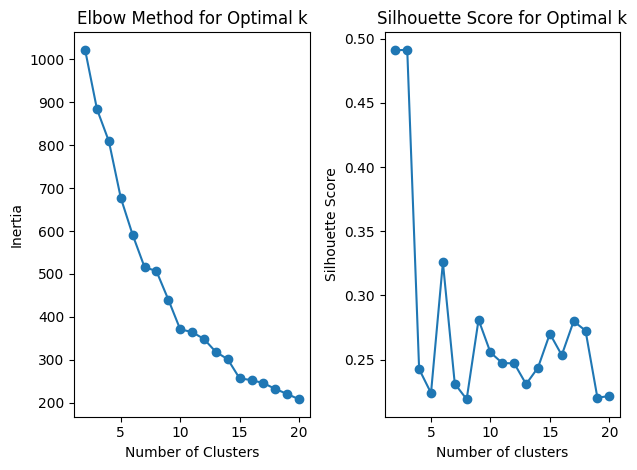

In [63]:
# optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores_km = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores_km.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Plot the elbow graph
# plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 21), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')


# Plot Silhouette score
plt.subplot(1, 2, 2)
plt.plot(range(2, 21), silhouette_scores_km, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


In [64]:
# Train K-Means with Best Parameters
kmeans_best = KMeans(**best_params, random_state=42)  # Use the best parameters found by GridSearchCV
kmeans_best.fit(X_train_scaled)

# Get cluster labels for both train and test sets
cluster_labels_train = kmeans_best.labels_
cluster_labels_test = kmeans_best.predict(X_test_scaled)